In [21]:
import numpy as np
import pandas as pd
import io
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

In [22]:
# Загрузка файла с уже удаленными таргетами

X = pd.read_excel('ADA_LR3_source.xlsx')
X.head()

,х1,х2,х3,х4,х5,х6,x7,x8,x9
0,8.5,16.3,6.8,5.6,17.4,163,151,23.6,2344
1,9.3,12.6,7.2,5.5,25.3,194,239,9.2,1809
2,8.7,4.6,6.5,4.2,16.2,152,192,26.9,2406
3,8.6,6.2,6.1,4.0,17.4,190,205,20.1,2023
4,8.1,11.4,7.7,6.4,5.9,183,198,22.0,1419


In [23]:
# Z-нормализация данных

mean = np.mean(X, axis=0)
deviation = np.std(X, axis=0)
X_norm = (X - mean) / deviation

X_norm.head()

,х1,х2,х3,х4,х5,х6,x7,x8,x9
0,-0.286871,0.380753,-0.578697,1.355041,0.039305,-0.089130,-0.151352,-0.585908,1.223650
1,0.047072,-0.747237,0.035964,1.242121,2.792850,0.432408,2.681192,-2.108728,0.152280
2,-0.203386,-3.186134,-1.039693,-0.225840,-0.378955,-0.274192,1.168356,-0.236928,1.347809
3,-0.245128,-2.698355,-1.654355,-0.451680,0.039305,0.365113,1.586800,-0.956038,0.580828
4,-0.453843,-1.113071,0.804291,2.258402,-3.969020,0.247346,1.361484,-0.755110,-0.628719


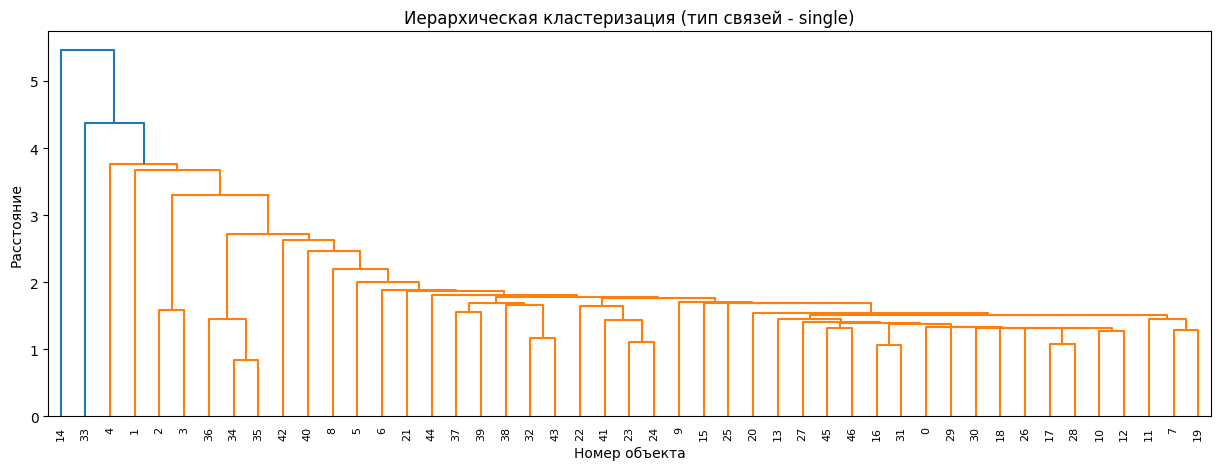

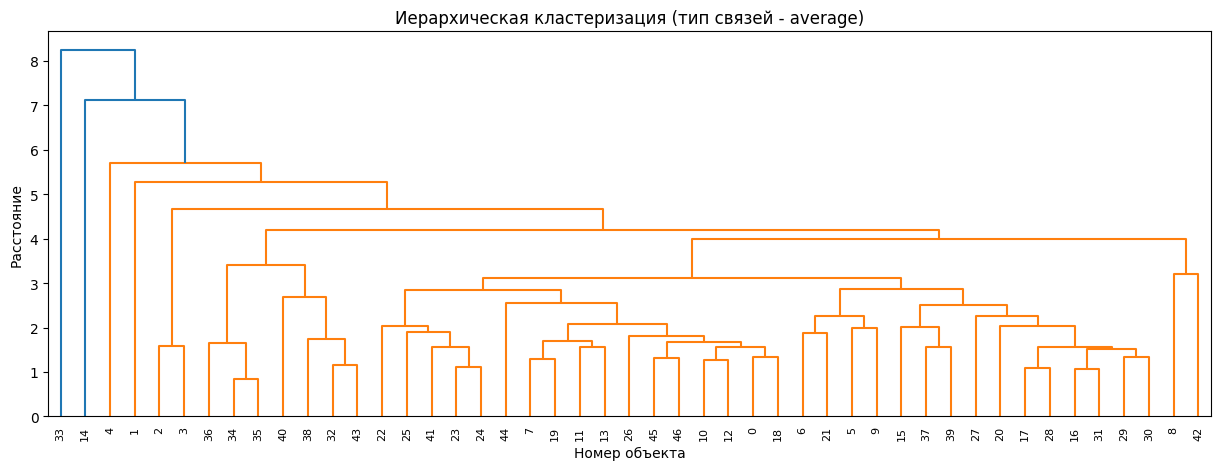

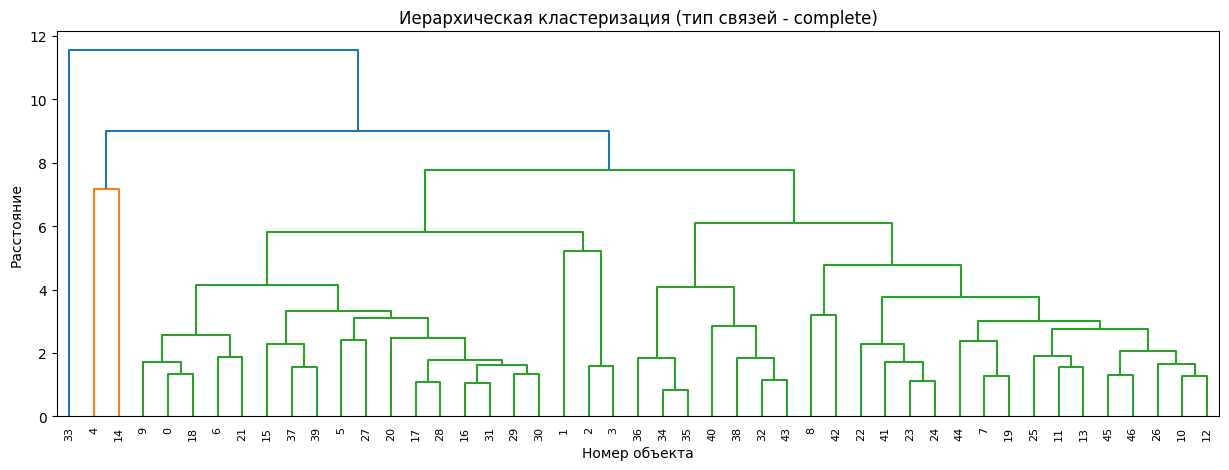

In [24]:
# Типы связей
# single - ближайший сосед, average - между центрами кластеров, complete - дальний сосед
linkage_types = ['single', 'average', 'complete']

for linkage_type in linkage_types:
  link = linkage(X_norm, method=linkage_type)
  plt.figure(figsize=(15, 5))
  plt.title(f'Иерархическая кластеризация (тип связей - {linkage_type})')
  plt.xlabel('Номер объекта')
  plt.ylabel('Расстояние')
  dendrogram(link)

In [29]:
from sklearn.cluster import AgglomerativeClustering

# Аггломеративная кластеризация с помощью библиотеки sklearn
model = AgglomerativeClustering(n_clusters=4, linkage='complete')
model.fit(X)
agg_labels = model.fit_predict(X_norm)
agg_labels

array([1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 3, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2,
       2, 2, 2])

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, get_scorer_names
from sklearn.model_selection import GridSearchCV

def davies_bouldin_scoring(estimator, X):
  estimator.fit(X)
  return davies_bouldin_score(X, estimator.labels_)

kmeans = KMeans(n_init=10)
param_grid = {'n_clusters': range(2, 9)}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(kmeans, param_grid, scoring=davies_bouldin_scoring)

# Обучение модели и подбор идеальных параметров
grid_search.fit(X_norm)

# Получение лучшего числа кластеров
best_n_clusters = grid_search.best_params_['n_clusters']

# Новая модель уже с указанным лучшим числом кластеров
best_k_means = KMeans(n_init=10, n_clusters = best_n_clusters)
best_k_means.fit_predict(X_norm)
kmeans_labels = best_k_means.labels_

print('Лучшее число кластеров:', grid_search.best_params_['n_clusters'])

Лучшее число кластеров: 3


In [36]:
from sklearn.metrics import rand_score

# Вычисление индекса Рэнда
rand_index = rand_score(agg_labels, kmeans_labels)
rand_index

0.6512488436632747

In [38]:
X_labeled = X_norm.copy()

# Добавление в датафрейм колонки "кластер"
X_labeled['Cluster'] = kmeans_labels

# Вычисление среднего значения признаков в каждом кластере
cluster_means = X_labeled.groupby('Cluster').mean()
cluster_means

,х1,х2,х3,х4,х5,х6,x7,x8,x9
Cluster,,,,,,,,,
0,-0.366382,0.353171,0.672578,0.564601,-0.281029,0.478072,0.579775,-0.644323,-0.190826
1,1.489520,-0.919992,0.172556,-1.204481,0.198088,-0.657402,-0.970358,1.235366,-1.161846
2,-0.335981,0.050785,-0.922184,-0.059781,0.242284,-0.242524,-0.202474,0.141911,0.850821
